# Notebook setup

## .. Import misc. Packages

In [1]:
print("Importing packages and set options")

Importing packages and set options


In [2]:
# Install misc packages
import pandas as pd; pd.set_option('display.max_columns', None); pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns; sns.set()
from lifelines import KaplanMeierFitter
from tqdm import tqdm 
import warnings
import gc
import os
import time

# Start timer
start_time = time.time()


# Silence warning from wrds
warnings.filterwarnings("ignore", category=FutureWarning, module="wrds.sql")

## .. Import Stata

In [3]:
print("Importing Stata")

Importing Stata


In [4]:
# Install stata packages
import stata_setup
try: 
    stata_setup.config("/usr/local/stata", "se", splash=False)
    njh_local_env = False
except: 
    stata_setup.config("/Applications/Stata", "se", splash=False)
    njh_local_env = True

from pystata import stata # type: ignore

In [5]:
stata.run("ssc install estout")
stata.run("ssc install reghdfe")
stata.run("ssc install ftools")


checking estout consistency and verifying not already installed...
all files already exist and are up to date.
checking reghdfe consistency and verifying not already installed...
all files already exist and are up to date.
checking ftools consistency and verifying not already installed...
installing into /home/statauser/ado/plus/...
installation complete.


In [6]:
# Set directory stub
if njh_local_env == True:
    directory_stub = "/Users/njhallman/GitHub"
else:
    directory_stub = "/workspaces"

In [7]:
print(directory_stub)

/workspaces


## .. Write some functions

In [8]:
print("Writing some functions")

Writing some functions


In [9]:
def add_tabular_environment(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        content = file.readlines()

    # Determine the number of columns by finding the first line with data
    for line in content:
        if line.strip() and '&' in line:
            num_columns = line.count('&') + 1
            break
    else:
        print("No data lines found to determine the number of columns.")
        return

    # Create the tabular start string based on the number of columns
    tabular_start = r"\begin{tabular}{" + "l" + "c" * (num_columns - 1) + r"}\\[-1.8ex]\hline \hline \\[-1.8ex]"
    tabular_end = r"\\[-1.8ex]\hline \hline \\[-1.8ex] \end{tabular}"

    # Modify the content by adding LaTeX tabular environment
    modified_content = tabular_start + "\n" + "".join(content) + tabular_end

    # Write the modified content back to the file
    with open(file_path, 'w') as file:
        file.write(modified_content)

    print(f"Tabular environment with {num_columns} columns added to {file_path}")

In [10]:
'''
Setup function to replace some of the
output of LaTeX files before sending to Overleaf
'''

def format_latex(file):
  #read input file
  fin = open(file, "rt")

  #read file contents to string
  data = fin.read()

  #Variables
  data = data.replace('retained', '\RETAINED')
  data = data.replace('promo', '\PROMOTED')
  data = data.replace('female\_pre\_2010', '\FEMALExPREX')
  data = data.replace('female\_2010\_2011', '\FEMALExXtoXI')
  data = data.replace('female\_2012\_2013', '\FEMALExXIItoXIII')
  data = data.replace('female\_2014\_2015', '\FEMALExXIVtoXV')
  data = data.replace('female\_2016\_2017', '\FEMALExXVItoXVII')
  data = data.replace('female\_2018\_2019', '\FEMALExXVIIItoXIX')
  data = data.replace('female\_post\_2019', '\FEMALExPOSTXIX')
  data = data.replace('female\_pre\_eq\_1', '\FEMALExPREEQONE')
  data = data.replace('female\_pre\_eq\_2', '\FEMALExPREEQTWO')
  data = data.replace('female\_pre\_eq\_3', '\FEMALExPREEQTHREE')
  data = data.replace('female\_post\_eq', '\FEMALExPOSTEQ')
  data = data.replace('post\_eq', '\POSTEQ')
  data = data.replace('pre\_eq\_1', '\PREEQONE')
  data = data.replace('pre\_eq\_2', '\PREEQTWO')
  data = data.replace('pre\_eq\_3', '\PREEQTHREE')
  data = data.replace('female', '\FEMALE')
  data = data.replace('topuniv', '\TOPUNIV')
  data = data.replace('masterorhigher', '\MASTERS')
  data = data.replace('api', '\APIRACE')
  data = data.replace('black', '\BLACKRACE')
  data = data.replace('other', '\OTHERRACE')
  data = data.replace('top\_university', '\TOPUNIVERSITY')


  # Add double lines to top and bottom to match other tables
  data = data.replace('toprule', '\[-1.8ex]\hline \hline \\\\[-1.8ex]')
  data = data.replace('bottomrule', '\[-1.8ex]\hline \hline \\\\[-1.8ex]')

  # Replace longtable and table formatting to make output tables just tabular
  data = data.replace('longtable', 'tabular')
  data = data.replace(r'\begin{table}[!htbp] \centering', '')
  data = data.replace(r'\begin{table}[!htbp] \centering', '')
  data = data.replace(r' \caption{}', '')
  data = data.replace(r'\label{}', '')
  data = data.replace(r'\end{table}', '')


  #close the input file
  fin.close()

  #open the input file in write mode
  fin = open(file, "wt")

  #overrite the input file with the resulting data
  fin.write(data)

  #close the file
  fin.close()

# Prepare Downloaded Data for Analysis

## .. Import and prep the Revelio data

In [11]:
print("Importing and prepping the combined Revelio data")

Importing and prepping the combined Revelio data


### ... Import the raw data

In [12]:
'''
Import the data. If original data files are available, use those. Otherwise use the most recently downloaded files. 
'''

if os.path.exists(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsPosUsr_1_of_4.feather'):

    ''' 
    Use the Revelio download that creates the exact tables in the paper (will only work if you have original files, 
    not included in the public repo because I cannot publicly distribute a commercial database)
    '''

    print('Original data found - using original data')

    # Read in the individual fsPosUsr files
    revFsPosUsr1 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsPosUsr_1_of_4.feather')
    revFsPosUsr2 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsPosUsr_2_of_4.feather')
    revFsPosUsr3 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsPosUsr_3_of_4.feather')
    revFsPosUsr4 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsPosUsr_4_of_4.feather')

    # Combine the individual fsPosUsr files
    revFsPosUsrRaw = pd.concat([revFsPosUsr1, revFsPosUsr2, revFsPosUsr3, revFsPosUsr4], ignore_index=True)

    '''
    Import and combine the financial services education data
    '''

    # Import individual files 
    revFsEdu1 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsEdu_1_of_4.feather')
    revFsEdu2 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsEdu_2_of_4.feather')
    revFsEdu3 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsEdu_3_of_4.feather')
    revFsEdu4 = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/MSData/revelioFsEdu_4_of_4.feather')

    # Combine the individual files
    revFsEduRaw = pd.concat([revFsEdu1, revFsEdu2, revFsEdu3, revFsEdu4], ignore_index=True)

else:

    '''
    Use a more recent version of Revelio data, which will 
    result in some (hopefully minor) differences from the publicly available version of the paper
    '''

    print('Original data NOT found - using newer data')

    # Get a list of PosUser files in the ../Data/Revelio directory
    files = [os.path.join(f"{directory_stub}/Gender-public/Analysis/Data/Revelio/CurrentData", f) for f in os.listdir(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/CurrentData') if f.startswith("revelioPosUsr_role_")]

    # Read and concatenate user and position files
    revFsPosUsrRaw = pd.concat([pd.read_feather(f) for f in files], ignore_index=True)

    # Read education file
    revFsEduRaw = pd.read_feather(f'{directory_stub}/Gender-public/Analysis/Data/Revelio/CurrentData/revelioEdu_role_combined.feather', columns=None)


Original data found - using original data


In [13]:
'''
Limit educational data to the rank of the highest rated univeristy attended by each user
'''

# Create a copy of the education file for modification
revFsEdu = revFsEduRaw.copy()

# Limit education data to bachelor, masters, MBA or doctorate degrees
revFsEdu = (
    revFsEdu.loc[(revFsEdu['degree'] == 'Bachelor') | 
                (revFsEdu['degree'] == 'Master') | 
                (revFsEdu['degree'] == 'MBA') | 
                (revFsEdu['degree'] == 'Doctor')]
)

degree_hierarchy = {
    'Doctor': 4,
    'MBA': 3,
    'Master': 2,
    'Bachelor': 1
}

revFsEdu['degree_rank'] = revFsEdu['degree'].map(degree_hierarchy)

# Convert dates to date format
revFsEdu['enddate'] = revFsEdu['enddate'].fillna(pd.to_datetime('2025-03-01'))
revFsEdu['enddate'] = pd.to_datetime(revFsEdu['enddate'])
revFsEdu['startdate'] = pd.to_datetime(revFsEdu['startdate'])


revFsEdu = revFsEdu.sort_values(['user_id','degree_rank','enddate'], ascending=[False, True, True]).groupby('user_id').tail(1)
revFsEdu = revFsEdu[['user_id', 'university_name', 'degree']]


In [14]:
'''
Standardize unviversity names
'''


school_mapping = {

    # UT Austin
    'The University of Texas at Austin': 'University of Texas at Austin',
    'McCombs School of Business at the University of Texas at Austin': 'University of Texas at Austin',

    # BYU
    'Brigham Young University': 'Brigham Young University',
    'Brigham Young University Marriott School of Business': 'Brigham Young University',

    # UIUC
    'University of Illinois at Urbana-Champaign': 'University of Illinois at Urbana-Champaign',
    'Gies College of Business': 'University of Illinois at Urbana-Champaign',

    # Indiana
    'Indiana University Bloomington': 'Indiana University Bloomington',
    'Kelley School of Business': 'Indiana University Bloomington',

    # Notre Dame
    'University of Notre Dame': 'University of Notre Dame',
    'Mendoza College of Business': 'University of Notre Dame',

    # Michigan
    'University of Michigan': 'University of Michigan',
    'Stephen M. Ross School of Business': 'University of Michigan',

    # UPenn
    'University of Pennsylvania': 'University of Pennsylvania',
    'Wharton School of Business at University of Pennsylvania': 'University of Pennsylvania',

    # USC
    'University of Southern California': 'University of Southern California',
    'USC Marshall School of Business': 'University of Southern California',

    # NYU
    'New York University': 'New York University',
    'The Leonard N Stern School of Business': 'New York University',
    'New York University School of Law': 'New York University',

    # OSU
    'The Ohio State University': 'Ohio State University',
    'Fisher College of Business': 'Ohio State University',

    # MIT
    'Massachusetts Institute of Technology': 'Massachusetts Institute of Technology',
    'MIT Sloan School of Management': 'Massachusetts Institute of Technology',

    # UC Berkeley
    'University of California Berkeley': 'University of California Berkeley',
    'Haas School of Business': 'University of California Berkeley',

    # CMU
    'Carnegie Mellon University': 'Carnegie Mellon University',
    'Tepper School of Business': 'Carnegie Mellon University',

    # UNC
    'University of North Carolina at Chapel Hill': 'University of North Carolina at Chapel Hill',
    'Kenan-Flagler Business School': 'University of North Carolina at Chapel Hill',

    # UVA
    'University of Virginia': 'University of Virginia',
    'University of Virginia Darden School of Business': 'University of Virginia',

    # Cornell
    'Cornell University': 'Cornell University',
    'Johnson Graduate School of Management': 'Cornell University',

    # Stanford
    'Stanford University': 'Stanford University',
    'Stanford Graduate School of Business': 'Stanford University',

    # Northwestern
    'Northwestern University': 'Northwestern University',
    'Kellogg School of Management at Northwestern University': 'Northwestern University',

    # U Chicago
    'The University of Chicago Booth School of Business': 'University of Chicago',
    'University of Chicago': 'University of Chicago',

    # Harvard
    'Harvard University': 'Harvard University',
    'Harvard Business School': 'Harvard University',
    'Harvard Law School': 'Harvard University',

    # Columbia
    'Columbia University in the City of New York': 'Columbia University',
    'Columbia Business School': 'Columbia University',
    'Columbia Law School': 'Columbia University',

    # Yale
    'Yale University': 'Yale University',
    'Yale School of Management': 'Yale University',

    # Princeton
    'Princeton University': 'Princeton University',

    # Duke
    'Duke University': 'Duke University',
    'The Fuqua School of Business': 'Duke University'
}

# Map university names to standardized names
revFsEdu['university_name'] = revFsEdu['university_name'].apply(lambda x: school_mapping.get(x, 'other'))

In [15]:
revFsEdu.groupby('university_name')['user_id'].nunique().sort_values(ascending=False).reset_index()

,university_name,user_id
0,other,2648608
1,New York University,34797
2,University of Texas at Austin,26951
3,Columbia University,25549
4,University of Southern California,24758
5,University of Pennsylvania,24187
6,Indiana University Bloomington,23481
7,University of Chicago,22065
8,University of Illinois at Urbana-Champaign,20471
9,Harvard University,19495


### ... Merge the positions and education data

In [16]:
'''
Merge the educational data with the user and position data
'''

# Merge
revFs = pd.merge(left = revFsPosUsrRaw, right = revFsEdu, how = 'left', on = 'user_id')

# Convert date columns to datetime
revFs['enddate'] = revFs['enddate'].fillna(pd.to_datetime('2025-01-14'))
revFs['enddate'] = pd.to_datetime(revFs['enddate'])
revFs['startdate'] = pd.to_datetime(revFs['startdate'])

#Check the number of unique users
unique_users_1 = len(revFs.drop_duplicates(subset = "user_id"))
unique_positoins_1 = len(revFs)
print(f'Unique users in full combined dataset: {unique_users_1:,}')
print(f'Unique positions in full combined dataset: {unique_positoins_1:,}')

Unique users in full combined dataset: 4,732,249
Unique positions in full combined dataset: 8,992,899


### ... Break out auditing and other financial services into separate files

In [17]:
'''
Map standardized audit firm names to the raw audit firm names
'''


auditFirmMapping = {
    # PwC variants
    'PwC': 'pwc',
    'PricewaterhouseCoopers': 'pwc',
    'PricewaterhouseCoopers LLP': 'pwc',
    'Price Waterhouse Coopers': 'pwc',
    'PriceWaterhouseCoopers': 'pwc',
    'Pricewaterhouse Coopers': 'pwc',
    'PricewaterhouseCoopers, LLP': 'pwc',
    
    # Deloitte variants
    'Deloitte': 'deloitte',
    'Deloitte & Touche': 'deloitte',
    'Deloitte & Touche LLP': 'deloitte',
    'Deloitte & Touche, LLP': 'deloitte',
    'Deloitte and Touche': 'deloitte',
    'Deloitte (Accounting Firm)': 'deloitte',
    
    # EY variants
    'EY': 'ey',
    'Ernst & Young': 'ey',
    'Ernst & Young LLP': 'ey',
    'Ernst & Young, LLP': 'ey',
    'Ernst and Young': 'ey',
    'E & Y': 'ey',
    
    # KPMG variants
    'KPMG': 'kpmg',
    'KPMG US': 'kpmg',
    'KPMG LLP': 'kpmg',
    'KPMG Audit': 'kpmg',
    'KPMG, LLP': 'kpmg',
    'KPMG Advisory': 'kpmg'
}

# Assign standardlized firm names based on mapping
revFs['aud_firm'] = revFs['company_raw'].map(auditFirmMapping)

# Define mapping of standardized firm names to auditor_key
auditFirmKeyMapping = {
    'pwc' : 1,
    'ey' : 2,
    'deloitte' : 3,
    'kpmg' : 4
}

# Assign auditor_key based on mapping
revFs['auditor_key'] = revFs['aud_firm'].map(auditFirmKeyMapping)

# Create the audit dataset as all auditing positions at the Big 4
revB4Aud = revFs.loc[(revFs['auditor_key'].notnull()) & (revFs['role_k1500'].isin(['audit', 'auditor']))]

# Create the other finanical services dataset as all non-auditing positions everywhere except the Big 4
revOtherFs = revFs.loc[(revFs['auditor_key'].isnull()) & ~(revFs['role_k1500'].isin(['audit', 'auditor']))]

In [18]:
# Delete the individual files to free up memory
del revFsPosUsrRaw, revFsEdu, revFsEduRaw, revFs
gc.collect()

0

### ... Print Status

In [19]:
'''
Print the time that has passed since the start of the analysis
'''

print("Data import complete")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Data import complete
Time elapsed: 1.07 minutes



## .. Work with the audit dataset

In [20]:
print("Working with the audit dataset")

Working with the audit dataset


In [ ]:
# Print the number of unique auditors and audit positions before data screens
ua1 = len(revB4Aud.drop_duplicates(subset='user_id'))
uap1 = len(revB4Aud)
print(f'Unique auditors: {ua1:,}')
print(f'Unique audit positions: {uap1:,}')

Unique auditors: 192,245
Unique audit positions: 292,897


In [22]:
'''
Drop positions with missing or incorrect dates
'''

# Keep rows where start data is before end date
revB4Aud = revB4Aud[revB4Aud['startdate'] <= revB4Aud['enddate']]

# Drop rows with null start data
revB4Aud = revB4Aud[~revB4Aud['startdate'].isnull()]

# Print the number of unique auditors and audit positions
uad1 = abs(ua1 - len(revB4Aud.drop_duplicates(subset='user_id')))
uapd1 = abs(uap1 - len(revB4Aud))

print(f'Less {uad1:,} auditors')
print(f'Less {uapd1:,} positions')

Less 2,478 auditors
Less 3,890 positions


In [23]:
'''
Drop user_ids that switch audit firms
'''

# Identify user_ids associated with more than one aud_firm
user_ids_multiple_firms = revB4Aud.groupby('user_id')['aud_firm'].nunique()
user_ids_multiple_firms = user_ids_multiple_firms[user_ids_multiple_firms > 1].index

# Drop these user_ids from the dataframe
revB4Aud = revB4Aud[~revB4Aud['user_id'].isin(user_ids_multiple_firms)]

#Check the number of unique users
uad2 = abs(ua1 - uad1 - len(revB4Aud.drop_duplicates(subset='user_id')))
uapd2 = abs(uap1 -  uapd1 - len(revB4Aud))
print(f'Less {uad2:,} auditors that change firms')
print(f'Less {uapd2:,} positions related to auditors that change firms')

Less 5,258 auditors that change firms
Less 13,652 positions related to auditors that change firms


In [ ]:
'''
Drop users missing educational data
'''

# Drop rows with missing educational data
revB4Aud = revB4Aud[revB4Aud['highest_degree'].notnull()] 

#Check the number of unique users
uad3 = abs(ua1 - uad1 - uad2 - len(revB4Aud.drop_duplicates(subset='user_id')))
uapd3 = abs(uap1 -  uapd1 - uapd2 - len(revB4Aud))
print(f'Less {uad3:,} auditors without educational data')
print(f'Less {uapd3:,} positions related to auditors without educational data')

Less 18,125 auditors without educational data
Less 24,495 positions related to auditors without educational data


In [25]:
'''
Find the first start-date and last end-date in the dataset for each user 
'''

# Find last end date
revB4Aud['user_firm_enddate'] = revB4Aud.groupby('user_id')['enddate'].transform('max')

# Find first start data
revB4Aud['user_firm_startdate'] = revB4Aud.groupby('user_id')['startdate'].transform('min')

In [26]:
'''
Map raw position titles into standardized position titles
'''

# Standardize intern posision
revB4Aud.loc[
    (revB4Aud['title_raw'].str.contains('intern', case=False, na=False)), 
    'rank'
] = 'intern'

# Standardize staff posision
revB4Aud.loc[
    (revB4Aud['title_raw'].str.contains('associate|assoc|assistant|staff', case=False, na=False)), 
    'rank'
] = 'staff'

revB4Aud.loc[
    (revB4Aud['title_raw'].str.lower().isin(['auditor', 'audit', 'assurance', 'external auditor', 'external audit', 'audit & assurance', 'audit assurance', 'audit and assurance'])) &
    (revB4Aud['user_firm_enddate'] - revB4Aud['user_firm_startdate'] < pd.Timedelta(days=3*365)), 
    'rank'
] = 'staff'

# Standardize senior posision
revB4Aud.loc[
    (revB4Aud['title_raw'].str.contains('sr|senior|in charge|in-charge', case=False, na=False)) & 
    (~revB4Aud['title_raw'].str.contains('mgr|manager|partner|assistant|staff', case=False, na=False)), 
    'rank'
] = 'senior'

# Standardize manager posision
revB4Aud.loc[
    (revB4Aud['title_raw'].str.contains('mgr|manager', case=False, na=False)) & 
    (~revB4Aud['title_raw'].str.contains('sr|senior|partner', case=False, na=False)), 
    'rank'
] = 'manager'

# Standardize senior manager posision
revB4Aud.loc[
    (revB4Aud['title_raw'].str.contains('sr|senior', case=False, na=False)) & 
    (revB4Aud['title_raw'].str.contains('mgr|manager', case=False, na=False)) & 
    (~revB4Aud['title_raw'].str.contains('partner|director', case=False, na=False)), 
    'rank'
] = 'senior manager'

# Standardize director posision
revB4Aud.loc[
    (revB4Aud['title_raw'].str.contains('director', case=False, na=False)) & 
    (~revB4Aud['title_raw'].str.contains('partner', case=False, na=False)), 
    'rank'
] = 'director'

# Standardize partner posision
revB4Aud.loc[
    (revB4Aud['title_raw'].str.contains('partner|owner|principal', case=False, na=False)) & 
    (~revB4Aud['title_raw'].str.contains('retired', case=False, na=False)), 
    'rank'
] = 'partner'

# Create the rank_num column based on the rank column
rankMapping = {
    'intern': 0,
    'staff': 1,
    'senior': 2,
    'manager': 3,
    'senior manager': 4,
    'director': 5,
    'partner': 6
}
revB4Aud['rank_num'] = revB4Aud['rank'].map(rankMapping)


In [ ]:
# Drop rows where rank is intern
revB4Aud = revB4Aud[revB4Aud['rank'] != 'intern']

#Check the number of unique users
uad4 = abs(ua1 - uad1 - uad2 - uad3 - len(revB4Aud.drop_duplicates(subset='user_id')))
uapd4 = abs(uap1 -  uapd1 - uapd2 - uapd3 - len(revB4Aud))
print(f'Less {uad4:,} auditors who only ever work as interns')
print(f'Less {uapd4:,} intern positions')

print()
print(revB4Aud['rank'].value_counts())

Less 19,127 auditors who only ever work as interns
Less 47,488 intern positions

rank
staff             77773
senior            76965
manager           23239
senior manager    11257
director           2062
partner            2028
Name: count, dtype: int64


In [28]:
'''
Create a varaible called bad_rank that is True if the user 
reports being a higher rank without also reporting any lower ranks
'''

# Create a bad_rank variable with a default value of False
revB4Aud['bad_rank'] = False

# Identify user_ids with at least one row with the rank 'partner'
user_ids_with_partner = revB4Aud[revB4Aud['rank'] == 'partner']['user_id'].unique()

# Identify user_ids with at least one row with the rank 'director'
user_ids_with_director = revB4Aud[revB4Aud['rank'] == 'director']['user_id'].unique()

# Identify user_ids with at least one row with the rank 'senior manager'
user_ids_with_senior_manager = revB4Aud[revB4Aud['rank'] == 'senior manager']['user_id'].unique()

# Identify user_ids with at least one row with the rank 'manager'
user_ids_with_manager = revB4Aud[revB4Aud['rank'] == 'manager']['user_id'].unique()

# Identify user_ids with at least one row with the rank 'senior'
user_ids_with_senior = revB4Aud[revB4Aud['rank'] == 'senior']['user_id'].unique()

# Identify user_ids with at least one row with the rank 'staff'
user_ids_with_staff = revB4Aud[revB4Aud['rank'] == 'staff']['user_id'].unique()



# Set bad_rank to True for user_ids that report being a senior without ever reporting being staff
revB4Aud['bad_rank'] = revB4Aud['user_id'].isin(np.setdiff1d(user_ids_with_senior, user_ids_with_staff))

# Set bad_rank to True for user_ids that report being a manager without ever reporting being a senior or staff
revB4Aud.loc[
    revB4Aud['user_id'].isin(np.setdiff1d(user_ids_with_manager, np.concatenate((user_ids_with_senior, user_ids_with_staff)))), 'bad_rank'] = True

# Set bad_rank to True for user_ids that report being a senior manager without ever reporting being a manager, senior or staff
revB4Aud.loc[
    revB4Aud['user_id'].isin(np.setdiff1d(user_ids_with_senior_manager, np.concatenate((user_ids_with_manager, user_ids_with_senior, user_ids_with_staff)))), 'bad_rank'] = True

# Set bad_rank to True for user_ids that report being a director without ever reporting being a senior manager, manager, senior or staff
revB4Aud.loc[
    revB4Aud['user_id'].isin(np.setdiff1d(user_ids_with_director, np.concatenate((user_ids_with_senior_manager, user_ids_with_manager, user_ids_with_senior, user_ids_with_staff)))), 'bad_rank'] = True

# Set bad_rank to True for user_ids that report being a partner without ever reporting being a director, senior manager, manager, senior or staff
revB4Aud.loc[
    revB4Aud['user_id'].isin(np.setdiff1d(user_ids_with_partner, np.concatenate((user_ids_with_director, user_ids_with_senior_manager, user_ids_with_manager, user_ids_with_senior, user_ids_with_staff)))), 'bad_rank'] = True


# Set bad_rank to True if the rank is null
revB4Aud.loc[revB4Aud['rank'].isnull(), 'bad_rank'] = True


# Set bad_rank to True for all rows with a given user_id if any row for that user_id has bad_rank equal to True
revB4Aud['bad_rank'] = revB4Aud.groupby('user_id')['bad_rank'].transform('any')


In [29]:
'''
Explode dataset to create user-year panel
'''

# Create a column that lists all the years the user was in the position
revB4Aud['position_year'] = revB4Aud.apply(lambda row: list(range(row['startdate'].year, row['enddate'].year + 1)), axis=1)

# Explode the position_year column so that data becomes user-year level instead of user-position level
revB4AudExp = (
    revB4Aud[['user_id', 'position_id', 'fullname', 'profile_summary', 'profile_title', 'state', 'metro_area', 'user_firm_startdate', 'user_firm_enddate', 'position_year', 'auditor_key',
            'aud_firm', 'rank', 'rank_num', 'bad_rank', 'sex_predicted', 'ethnicity_predicted', 'profile_linkedin_url', 'university_name', 'degree']].explode('position_year', ignore_index = True)
)
    
# Sort the DataFrame by user_id, position_year, and rank_num
revB4AudExp = revB4AudExp.sort_values(['user_id', 'position_year', 'rank_num'])

# Drop duplicate user_id-position_year pairs, keeping the one with the highest rank_num
revB4AudExp = revB4AudExp.drop_duplicates(['user_id', 'position_year'], keep='last')

In [ ]:
ua2 = len(revB4AudExp.drop_duplicates(subset='user_id'))
uay1 = len(revB4AudExp)

print(f"Unique users : {ua2:,}")
print(f"Users-years: {uay1:,}")

Unique users : 147,257
Users-years: 766,730


In [31]:
'''
Create variables for the user-year panel
'''

revB4AudExp['userid'] = revB4AudExp['user_id'].astype(int)
revB4AudExp['year'] = revB4AudExp['position_year'].astype(int)
revB4AudExp['auditorkey'] = revB4AudExp['auditor_key'].astype(int)
revB4AudExp['retained'] = revB4AudExp['user_firm_enddate'].dt.year > revB4AudExp['year']; revB4AudExp['retained'] = revB4AudExp['retained'].astype(int)
revB4AudExp['female'] = 0;revB4AudExp.loc[revB4AudExp['sex_predicted'] == 'F', 'female'] = 1
revB4AudExp['rank_num'] = revB4AudExp['rank_num'].fillna(-1); revB4AudExp['positionrank'] = revB4AudExp['rank_num'].astype(int)
revB4AudExp['badrankdummy'] = 0; revB4AudExp.loc[revB4AudExp['bad_rank'] == True, 'badrankdummy'] = 1
revB4AudExp['yearswithfirm'] = revB4AudExp['year'] - revB4AudExp['user_firm_startdate'].dt.year
revB4AudExp['yearfirst'] = revB4AudExp['user_firm_startdate'].dt.year

revB4AudExp['white'] = (revB4AudExp['ethnicity_predicted'] == 'White').astype(int)
revB4AudExp['api'] = (revB4AudExp['ethnicity_predicted'] == 'API').astype(int)
revB4AudExp['black'] = (revB4AudExp['ethnicity_predicted'] == 'Black').astype(int)
revB4AudExp['other'] = (~revB4AudExp['ethnicity_predicted'].isin(['White', 'API', 'Black'])).astype(int)

revB4AudExp['masterorhigher'] = revB4AudExp['degree'].isin(['Master', 'MBA', 'Doctor']).astype(int)
revB4AudExp['top_university'] = (revB4AudExp['university_name'] != 'other').astype(int)

revB4AudExp['cpa'] = 0; revB4AudExp.loc[(revB4AudExp['profile_summary'].str.contains('cpa', case=False, na=False)) | #Can't seem to reliably identify CPAs
                                        (revB4AudExp['profile_summary'].str.contains('certified public acc', case=False, na=False))  |
                                        (revB4AudExp['profile_title'].str.contains('cpa', case=False, na=False)) | 
                                        (revB4AudExp['profile_title'].str.contains('certified public acc', case=False, na=False))  |
                                        (revB4AudExp['profile_linkedin_url'].str.contains('cpa', case=False, na=False)) | 
                                        (revB4AudExp['profile_linkedin_url'].str.contains('certified public acc', case=False, na=False))  |
                                        (revB4AudExp['fullname'].str.contains('cpa', case=False, na=False)) |
                                        (revB4AudExp['fullname'].str.contains('certified public acc', case=False, na=False)), 'cpa'] = 1


# Calculate the within-userid rank increase flag
revB4AudExp.sort_values(by=["userid", "year"], inplace=True)
revB4AudExp["promo"] = (
    revB4AudExp.groupby("userid")["positionrank"].diff().gt(0).astype(int)
)

# Shift the promo flag by one year within each userid group
revB4AudExp["promo"] = (
    revB4AudExp.groupby("userid")["promo"].shift(-1).fillna(0).astype(int)
)

# Create dummy variables for each two-year period
years = list(range(2010, 2020, 2))

for start_year in years:
    end_year = start_year + 1
    revB4AudExp[f'year_{start_year}_{end_year}'] = ((revB4AudExp['year'] == start_year) | (revB4AudExp['year'] == end_year)).astype(int)

# Create a dummy variable for all years prior to 2010
revB4AudExp['year_pre_2010'] = (revB4AudExp['year'] < 2010).astype(int)
revB4AudExp['year_post_2019'] = (revB4AudExp['year'] > 2019).astype(int)

# Create interaction terms between female and each two-year period dummy
for start_year in years:
    end_year = start_year + 1
    revB4AudExp[f'female_{start_year}_{end_year}'] = revB4AudExp['female'] * revB4AudExp[f'year_{start_year}_{end_year}']

# Create interaction term between female and the pre-2010 dummy
revB4AudExp['female_pre_2010'] = revB4AudExp['female'] * revB4AudExp['year_pre_2010']
revB4AudExp['female_post_2019'] = revB4AudExp['female'] * revB4AudExp['year_post_2019']

# Create the hazard and time variables for the cox hazard model
revB4AudExp['termination'] = 1 - revB4AudExp['retained']
revB4AudExp['time'] = revB4AudExp['year'] - revB4AudExp['yearfirst'] + 1

# Create pre/post equalized family leave policy variables
revB4AudExp['post_eq'] = 0
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 1) & (revB4AudExp['year'] >= 2014), 'post_eq'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 2) & (revB4AudExp['year'] >= 2016), 'post_eq'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 3) & (revB4AudExp['year'] >= 2016), 'post_eq'] = 1

revB4AudExp['pre_eq_1'] = 0
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 1) & (revB4AudExp['year'] == 2013), 'pre_eq_1'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 2) & (revB4AudExp['year'] == 2015), 'pre_eq_1'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 3) & (revB4AudExp['year'] == 2015), 'pre_eq_1'] = 1

revB4AudExp['pre_eq_2'] = 0
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 1) & (revB4AudExp['year'] == 2012), 'pre_eq_2'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 2) & (revB4AudExp['year'] == 2014), 'pre_eq_2'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 3) & (revB4AudExp['year'] == 2014), 'pre_eq_2'] = 1

revB4AudExp['pre_eq_3'] = 0
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 1) & (revB4AudExp['year'] == 2011), 'pre_eq_3'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 2) & (revB4AudExp['year'] == 2013), 'pre_eq_3'] = 1
revB4AudExp.loc[(revB4AudExp['auditorkey'] == 3) & (revB4AudExp['year'] == 2013), 'pre_eq_3'] = 1

revB4AudExp['female_post_eq'] = revB4AudExp['female'] * revB4AudExp['post_eq']
revB4AudExp['female_pre_eq_1'] = revB4AudExp['female'] * revB4AudExp['pre_eq_1']
revB4AudExp['female_pre_eq_2'] = revB4AudExp['female'] * revB4AudExp['pre_eq_2']
revB4AudExp['female_pre_eq_3'] = revB4AudExp['female'] * revB4AudExp['pre_eq_3']

# Drop auditor-years after 2023
revB4AudExp = revB4AudExp[revB4AudExp['position_year'] <= 2023]

# Replace empty metro_area strings with NaN
revB4AudExp['metro_area'] = revB4AudExp['metro_area'].replace("", np.nan)

# Convert 'metro_area' to categorical codes, keeping NaN values
revB4AudExp['metro_area_code'] = revB4AudExp['metro_area'].astype('category').cat.codes

# Set codes to NaN where metro_area was NaN
revB4AudExp.loc[revB4AudExp['metro_area'].isna(), 'metro_area_code'] = np.nan

revB4AudStata = revB4AudExp[['userid', 'year', 'auditorkey', 'retained', 'promo', 'female', 'ethnicity_predicted', 
    'positionrank', 'rank', 'badrankdummy', 'masterorhigher', 'yearswithfirm', 'yearfirst', 'cpa', 'white', 'api', 'black', 
    'other', 'metro_area', 'user_firm_startdate', 'user_firm_enddate', 'female_pre_2010', 'female_2010_2011', 'female_2012_2013', 
    'female_2014_2015', 'female_2016_2017', 'female_2018_2019', 'female_post_2019', 'termination', 'time', 'female_pre_eq_3', 
    'female_pre_eq_2', 'female_pre_eq_1', 'female_post_eq', 'pre_eq_1', 'pre_eq_2', 'pre_eq_3', 'post_eq', 'metro_area_code', 
    'university_name', 'top_university']].copy()

In [ ]:
uad5 = abs(ua2 - len(revB4AudExp.drop_duplicates(subset='user_id')))
uayd1 = abs(uay1 - len(revB4AudExp))

print(f"Less {uad5:,} auditors that only appear after 2023")
print(f"Less {uayd1:,} auditor-years after 2023")

Less 1,684 auditors that only appear after 2023
Less 53,116 auditor-years after 2023


In [ ]:
'''
Print user totals
'''

ua3 = len(revB4AudStata.drop_duplicates(subset='userid'))
uay2 = len(revB4AudStata)

ua4 = len(revB4AudStata.loc[revB4AudStata['badrankdummy'] == 0].drop_duplicates(subset = 'userid'))
uay3 = len(revB4AudStata.loc[revB4AudStata['badrankdummy'] == 0])

uad6 = abs(ua3 - ua4)
uayd2 = abs(uay2 - uay3)

print(f"Unique users : {ua3:,}")
print(f"Users-years: {uay2:,}")

print(f"Unique users with good ranks: {ua4:,}")
print(f"User-years with good ranks: {uay3:,}")


Unique users : 145,573
Users-years: 713,614
Unique users with good ranks: 70,516
User-years with good ranks: 284,999


In [34]:
'''
Print the time that has passed since the start of the analysis
'''

print("Processing audit data complete")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Processing audit data complete
Time elapsed: 1.22 minutes



## .. Work other financial services dataset

In [35]:
print("Working with the other financial services dataset")

Working with the other financial services dataset


In [36]:
uw1 = len(revOtherFs.drop_duplicates(subset='user_id'))
uwp1 = len(revOtherFs)
print(f'Unique fs employees: {uw1:,}')
print(f'Unique fs positions: {uwp1:,}')

Unique fs employees: 4,289,903
Unique fs positions: 7,682,481


In [37]:
'''
Drop positions with missing or incorrect dates
'''

# Keep rows where start data is before end date
revOtherFs = revOtherFs[revOtherFs['startdate'] <= revOtherFs['enddate']]

# Drop rows with null start data
revOtherFs = revOtherFs[~revOtherFs['startdate'].isnull()]

# Print the number of unique auditors and audit positions
uwd1 = abs(uw1 - len(revOtherFs.drop_duplicates(subset='user_id')))
uwpd1 = abs(uwp1 - len(revOtherFs))

print(f'Less {uwd1:,} workers that only have positions with missing or incorrect start dates')
print(f'Less {uwpd1:,} positions with incorrect or misisng start dates')

Less 490,118 workers that only have positions with missing or incorrect start dates
Less 587,445 positions with incorrect or misisng start dates


In [38]:
# Limit to positions with a valid company ID
revOtherFs = revOtherFs[revOtherFs['ultimate_parent_rcid'].notnull()]
revOtherFs = revOtherFs[~revOtherFs['company_raw'].str.contains("self-employed", case=False, na=False)]
revOtherFs = revOtherFs[~revOtherFs['company_raw'].str.contains("self employed", case=False, na=False)]
revOtherFs = revOtherFs[~revOtherFs['company_raw'].str.contains("h&r block", case=False, na=False)]

# Print the number of unique auditors and audit positions
uwd2 = abs(uw1 - uwd1 - len(revOtherFs.drop_duplicates(subset='user_id')))
uwpd2 = abs(uwp1 - uwpd1 - len(revOtherFs))

print(f'Less {uwd2:,} workers that only work for firms without a valid company ID')
print(f'Less {uwpd2:,} positions with firms that without a valid company ID')

Less 496,465 workers that only work for firms without a valid company ID
Less 1,105,800 positions with firms that without a valid company ID


In [39]:
'''
Drop users missing educational data
'''

# Drop rows with missing educational data
revOtherFs = revOtherFs[revOtherFs['highest_degree'].notnull()] 

# Print the number of unique auditors and audit positions
uwd3 = abs(uw1 - uwd1 - uwd2 - len(revOtherFs.drop_duplicates(subset='user_id')))
uwpd3 = abs(uwp1 - uwpd1 - uwpd2 - len(revOtherFs))

print(f'Less {uwd3:,} workers without educational data')
print(f'Less {uwpd3:,} positions associated with workers missing educational data')

Less 741,695 workers without educational data
Less 1,094,455 positions associated with workers missing educational data


In [40]:
'''
Drop intern positions
'''

# Drop rows with missing educational data
revOtherFs = revOtherFs[~(revOtherFs['title_raw'].str.contains('intern', case=False, na=False))] 

# Print the number of unique auditors and audit positions
uwd4 = abs(uw1 - uwd1 - uwd2 - uwd3 - len(revOtherFs.drop_duplicates(subset='user_id')))
uwpd4 = abs(uwp1 - uwpd1 - uwpd2 - uwpd3 - len(revOtherFs))

print(f'Less {uwd4:,} workers wwho are only ever interns')
print(f'Less {uwpd4:,} intern positions')

Less 123,075 workers wwho are only ever interns
Less 320,476 intern positions


In [41]:
'''
Explode the dataset to the employee-year level - no need to do seperate positions as not tranking rank
'''

# Sort by user_id, ultimate_parent_rcid, then startdate
revOtherFs = revOtherFs.sort_values(['user_id', 'ultimate_parent_rcid', 'startdate'])

#Flag where a new continuous spell begins (change in user, company, or a gap in dates more than 60 days)
revOtherFs['new_spell'] = (
    (revOtherFs['user_id'] != revOtherFs['user_id'].shift(1)) |
    (revOtherFs['ultimate_parent_rcid'] != revOtherFs['ultimate_parent_rcid'].shift(1)) 
).astype(int)


# Create a unique ID for each continuous user-company spell
revOtherFs['spell_id'] = revOtherFs['new_spell'].cumsum()

# For each spell, compute the earliest start date and latest end date
revOtherFs['spell_startdate'] = revOtherFs.groupby('spell_id')['startdate'].transform('min')
revOtherFs['spell_enddate'] = revOtherFs.groupby('spell_id')['enddate'].transform('max')

# Drop duplicate user_id-spell_id pairs
revOtherFs = revOtherFs.drop_duplicates(['user_id', 'spell_id'], keep='last')

# Create a column that lists all the years the user was in the position
revOtherFs['position_year'] = revOtherFs.apply(lambda row: list(range(row['spell_startdate'].year, row['spell_enddate'].year + 1)), axis=1)

# Explode the position_year column so that data becomes user-year level instead of user-position level
revOtherFsExp = (
    revOtherFs[['user_id', 'fullname', 'profile_summary', 'profile_title', 'state', 'metro_area', 'spell_startdate', 'spell_enddate', 'position_year', 'sex_predicted', 'ethnicity_predicted', 'profile_linkedin_url', 'ultimate_parent_rcid', 'company_raw', 'role_k1500', 'degree', 'university_name']].explode('position_year', ignore_index = True)
)

# Sort the DataFrame by user_id, position_year
revOtherFsExp = revOtherFsExp.sort_values(['user_id', 'position_year', 'spell_enddate'])

# Drop duplicate user_id-position_year pairs
revOtherFsExp = revOtherFsExp.drop_duplicates(['user_id', 'position_year'], keep='last')

# Print the number of unique auditors and audit positions
uw2 = len(revOtherFsExp.drop_duplicates(subset='user_id'))
uwy1 = len(revOtherFsExp)
print(f'Unique workers after exp {uw2:,}')
print(f'Unique worker-years after exp {uwy1:,}')

Unique workers after exp 2,438,550
Unique worker-years after exp 23,334,598


In [42]:
'''
Print user totals
'''

revOtherFsExp = revOtherFsExp[revOtherFsExp['position_year'] <= 2023]

# Print the number of unique auditors and audit positions
uwd5 = abs(uw2 - len(revOtherFsExp.drop_duplicates(subset='user_id')))
uwyd1 = abs(uwy1 - len(revOtherFsExp))

print(f'Less {uwd5:,} workers than only appear after 2023')
print(f'Less {uwyd1:,} worker-years after 2023')

Less 40,631 workers than only appear after 2023
Less 2,208,555 worker-years after 2023


In [43]:
'''
Create variables for the user-year panel
'''

revOtherFsExp['userid'] = revOtherFsExp['user_id'].astype(int)
revOtherFsExp['year'] = revOtherFsExp['position_year'].astype(int)
revOtherFsExp['retained'] = revOtherFsExp['spell_enddate'].dt.year > revOtherFsExp['year']; revOtherFsExp['retained'] = revOtherFsExp['retained'].astype(int)
revOtherFsExp['female'] = 0;revOtherFsExp.loc[revOtherFsExp['sex_predicted'] == 'F', 'female'] = 1
revOtherFsExp['yearswithfirm'] = revOtherFsExp['year'] - revOtherFsExp['spell_startdate'].dt.year
revOtherFsExp['yearfirst'] = revOtherFsExp['spell_startdate'].dt.year

revOtherFsExp['white'] = (revOtherFsExp['ethnicity_predicted'] == 'White').astype(int)
revOtherFsExp['api'] = (revOtherFsExp['ethnicity_predicted'] == 'API').astype(int)
revOtherFsExp['black'] = (revOtherFsExp['ethnicity_predicted'] == 'Black').astype(int)
revOtherFsExp['other'] = (~revOtherFsExp['ethnicity_predicted'].isin(['White', 'API', 'Black'])).astype(int)

revOtherFsExp['masterorhigher'] = revOtherFsExp['degree'].isin(['Master', 'MBA', 'Doctor']).astype(int)
revOtherFsExp['top_university'] = (revOtherFsExp['university_name'] != 'other').astype(int)

# Create dummy variables for each two-year period
years = list(range(2010, 2020, 2))

for start_year in years:
    end_year = start_year + 1
    revOtherFsExp[f'year_{start_year}_{end_year}'] = ((revOtherFsExp['year'] == start_year) | (revOtherFsExp['year'] == end_year)).astype(int)

# Create a dummy variable for all years prior to 2010
revOtherFsExp['year_pre_2010'] = (revOtherFsExp['year'] < 2010).astype(int)
revOtherFsExp['year_post_2019'] = (revOtherFsExp['year'] > 2019).astype(int)

# Create interaction terms between female and each two-year period dummy
for start_year in years:
    end_year = start_year + 1
    revOtherFsExp[f'female_{start_year}_{end_year}'] = revOtherFsExp['female'] * revOtherFsExp[f'year_{start_year}_{end_year}']

# Create interaction term between female and the pre-2010 dummy
revOtherFsExp['female_pre_2010'] = revOtherFsExp['female'] * revOtherFsExp['year_pre_2010']
revOtherFsExp['female_post_2019'] = revOtherFsExp['female'] * revOtherFsExp['year_post_2019']

revOtherFsStata = revOtherFsExp[['userid', 'year', 'retained', 'female', 'ethnicity_predicted', 'masterorhigher', 'yearswithfirm', 'yearfirst', 'white', 'api', 'black', 'other', 'metro_area', 'ultimate_parent_rcid', 'company_raw', 'role_k1500', 'female_pre_2010', 'female_2010_2011', 'female_2012_2013', 'female_2014_2015', 'female_2016_2017', 'female_2018_2019', 'female_post_2019', 'university_name', 'top_university']].copy()

In [44]:
# Print the number of unique auditors and audit positions
uw3 = len(revOtherFsStata.drop_duplicates(subset='userid'))
uwy2 = len(revOtherFsStata)
print(f'Unique workers {uw3:,}')
print(f'Unique worker-years {uwy2:,}')

Unique workers 2,397,919
Unique worker-years 21,126,043


In [45]:
'''
Print the time that has passed since the start of the analysis
'''

print("Processing other financial services data complete")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Processing other financial services data complete
Time elapsed: 2.84 minutes



# Create Tables and Figures

## .. Create Tables

#### .... List of financial services roles

In [46]:
print("Creating a table listing financial services roles")

Creating a table listing financial services roles


In [47]:
'''
Create table with the set of roles used
'''

# Read in a list of unique roles/mapping to FS in the Revelio data
fsm_list = [
    "actuarial",
    "actuarial analyst",
    "actuary",
    "aml analyst",
    "audit",
    "auditor",
    "banking consultant",
    "broker",
    "brokerage",
    "business controller",
    "capital markets",
    "cfo",
    "commercial finance",
    "commercial underwriter",
    "controller",
    "credit analyst",
    "equity analyst",
    "equity research",
    "equity research analyst",
    "finance controller",
    "financial adviser",
    "financial analyst fp a",
    "financial consultant",
    "financial controller",
    "financial officer",
    "financial planner",
    "financial planning",
    "financial planning analysis",
    "financial planning analyst",
    "financial reporting",
    "financial reporting analyst",
    "fraud analyst",
    "fraud investigator",
    "investment analyst",
    "investment banking",
    "investment banking analyst",
    "investment consultant",
    "investments",
    "mergers acquisitions",
    "portfolio analyst",
    "pricing analyst",
    "project controller",
    "quantitative analyst",
    "sap fico consultant",
    "stock controller",
    "tax",
    "tax accountant",
    "tax analyst",
    "tax consultant",
    "trade finance",
    "trader",
    "trading",
    "underwriter",
    "underwriting"
]

# Sort the list alphabetically
fsm_list.sort()

# Split the list into two columns
half = len(fsm_list) // 2 + len(fsm_list) % 2  # Ensure the first column has one extra row if odd
column1 = fsm_list[:half]
column2 = fsm_list[half:]

# Create the LaTeX table
with open(f"{directory_stub}/Gender-public/LaTeX/Tables/rolesTable.tex", 'w') as fout:
    fout.write(r"""
\centering
\begin{tabular}{p{7cm}p{7cm}}
\toprule
Column 1 & Column 2 \\
\midrule
""")
    # Add rows to the table
    for i in range(half):
        col1 = column1[i] if i < len(column1) else ""
        col2 = column2[i] if i < len(column2) else ""
        fout.write(f"{col1} & {col2} \\\\\n")

    fout.write(r"""
\bottomrule
\end{tabular}
""")


In [48]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 2.85 minutes



#### .... List of top employers in other financial services sample

In [49]:
print("Creating a table listing top employers in the other financial services sample")

Creating a table listing top employers in the other financial services sample


In [50]:
# Define the mapping of company names to their standardized names
company_mapping = {
    'Morgan Stanley': 'Morgan Stanley',
    'Bank of America': 'Bank of America',
    'Wells Fargo': 'Wells Fargo',
    'Goldman Sachs': 'Goldman Sachs',
    'Citi': 'Citi',
    'Merrill Lynch': 'Merrill Lynch',
    'JPMorgan Chase & Co.': 'JPMorgan Chase',
    'J.P. Morgan': 'JPMorgan Chase',
    'Fidelity Investments': 'Fidelity Investments',
    'UBS': 'UBS',
    'Credit Suisse': 'Credit Suisse',
    'Bank of America Merrill Lynch': 'Bank of America',
    'Deutsche Bank': 'Deutsche Bank',
    'Charles Schwab': 'Charles Schwab',
    'Merrill Lynch Wealth Management': 'Merrill Lynch',
    'Prudential Financial': 'Prudential Financial',
    'RSM US LLP': 'RSM US LLP',
    'BNY Mellon': 'BNY Mellon',
    'Wells Fargo Advisors': 'Wells Fargo',
    'Edward Jones': 'Edward Jones',
    'BlackRock': 'BlackRock',
    'U.S. Bank': 'U.S. Bank',
    'PNC': 'PNC',
    'Capital One': 'Capital One',
    'State Street': 'State Street',
    'JPMorgan Chase': 'JPMorgan Chase',
    'Lehman Brothers': 'Lehman Brothers',
    'Vanguard': 'Vanguard',
    'Ameriprise Financial Services, LLC': 'Ameriprise Financial Services, LLC',
    'Northwestern Mutual': 'Northwestern Mutual',
    'AIG': 'AIG',
    'GE Capital': 'GE Capital',
    'Internal Revenue Service': 'Internal Revenue Service',
    'Travelers': 'Travelers',
    'MetLife': 'MetLife',
    'Liberty Mutual Insurance': 'Liberty Mutual Insurance',
    'Aon': 'Aon',
    'CBRE': 'CBRE',
    'Raymond James': 'Raymond James',
    'HSBC': 'HSBC',
    'BDO USA, LLP': 'BDO USA, LLP',
    'New York Life Insurance Company': 'New York Life Insurance Company',
    'Primerica': 'Primerica',
    'IBM': 'IBM',
    'Coldwell Banker Residential Brokerage': 'Coldwell Banker Residential Brokerage',
    'RBC Capital Markets': 'RBC Capital Markets',
    'Barclays Investment Bank': 'Barclays Investment Bank',
    'Citigroup': 'Citi',
    'Arthur Andersen & Co.': 'Arthur Andersen'
}

# Standardize the company names in the DataFrame
revOtherFsStata['company_raw_standardized'] = revOtherFsStata['company_raw'].replace(company_mapping)

# Replace "&" with "\&" in values of company_raw in revOtherFsStata
revOtherFsStata['company_raw_standardized'] = revOtherFsStata['company_raw_standardized'].str.replace('&', r'\&')

# Get the top company_raw_standardized by row count in revOtherFsStata
top_companies = revOtherFsStata['company_raw_standardized'].value_counts().head(50)

# Split the list into two columns
half = len(top_companies) // 2 + len(top_companies) % 2  # Ensure the first column has one extra row if odd
column1 = top_companies.index[:half]
column2 = top_companies.index[half:]

# Create the LaTeX table
with open(f"{directory_stub}/Gender-public/LaTeX/Tables/topCompanies.tex", 'w') as fout:
    fout.write(r"""
\centering
\begin{tabular}{p{7cm}p{7cm}}
\toprule
Column 1 & Column 2 \\
\midrule
""")
    # Add rows to the table
    for i in range(half):
        col1 = column1[i] if i < len(column1) else ""
        col2 = column2[i] if i < len(column2) else ""
        fout.write(f"{col1} & {col2} \\\\\n")

    fout.write(r"""
\bottomrule
\end{tabular}
""")

In [51]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 3.75 minutes



#### .... Sample construction

In [52]:
print("Creating a table listing the sample construction")

Creating a table listing the sample construction


In [53]:
# Write a tex file to create the auditing sample design table
with open(f"{directory_stub}/Gender-public/LaTeX/Tables/sampleDesign.tex", 'w') as fout:
    fout.write(r"\begin{tabular}{ l c c c}")
    fout.write(r"\\[-1.8ex]\hline \hline \\[-1.8ex]")
    fout.write(r"\underline{Auditor sample}")
    fout.write(r"& \underline{Unique employees} & \underline{Unique positions} & \underline{Employee-years} ")
    fout.write(r"\\Auditors associated with Big 4 firms in Revelio data & " + f"{ua1:,.0f} & {uap1:,.0f} & {''}")
    fout.write(r"\\ \quad Less positions with missing or invalid start/end dates &" + f"({uad1 :,.0f}) & ({uapd1:,.0f}) & {''}")
    fout.write(r"\\ \quad Less auditors that move between B4 firms &" + f"({uad2 :,.0f}) & ({uapd2:,.0f}) & {''}")
    fout.write(r"\\ \quad Less auditors missing educational data &" + f"({uad3 :,.0f}) & ({uapd3:,.0f}) & {''}")
    fout.write(r"\\ \quad Less internship positions &" + r"\underline{" + f"({uad4 :,.0f})" + r"} & " + f"({uapd4:,.0f})" + r" " + f"& {''}")
    fout.write(r"\\ Exploded to create auditor-year sample &" + f"{ua2:,.0f} &  & {uay1:,.0f}")
    fout.write(r"\\ \quad Less auditor-years after 2023 &" + r"\underline{" + f"({uad5:,.0f})" + r"} & & \underline{" + f"({uayd1:,.0f})" + r"}")
    fout.write(r"\\ Primary sample &" + r"" + f"{ua3 :,.0f}" + r"& &" + f"{uay2:,.0f}" + r"")
    fout.write(r"\\ \quad Less observations without reliable ranks &" + r"\underline{" + f"({uad6 :,.0f})" + r"} & & \underline{" + f"({uayd2:,.0f})" + r"}")
    fout.write(r"\\ Sample for rank and promotion analysis &" + f"{ua4:,.0f} &  & {uay3:,.0f}")



    
    fout.write(r"\\\\ \underline{Other financial services sample} & & &")
    fout.write(r"\\Employees in finanical services positions comparable to auditing & " + f"{uw1:,.0f} & {uwp1:,.0f} & {''}")
    fout.write(r"\\ \quad Less positions with missing or invalid start/end dates &" + f"({uwd1 :,.0f}) & ({uwpd1:,.0f}) & {''}")
    fout.write(r"\\ \quad Less excluded companies (e.g., self-employed, H\&R Block, no company ID) &" + f"({uwd2 :,.0f}) & ({uwpd2:,.0f}) & {''}")
    fout.write(r"\\ \quad Less employees missing educational data &" + f"({uwd3 :,.0f}) & ({uwpd3:,.0f}) & {''}")
    fout.write(r"\\ \quad Less internship positions &" + r"\underline{" + f"({uwd4 :,.0f})" + r"} & " + f"({uwpd4:,.0f})" + r" " + f"& {''}")
    fout.write(r"\\ Exploded to create employee-year sample &" + f"{uw2:,.0f} &  & {uwy1:,.0f}")
    fout.write(r"\\ \quad Less employee-years after 2023 &" + r"\underline{" + f"({uwd5:,.0f})" + r"} & & \underline{" + f"({uwyd1:,.0f})" + r"}")
    fout.write(r"\\ Primary sample &" + r"" + f"{uw3 :,.0f}" + r"& &" + f"{uwy2:,.0f}" + r"")

    fout.write(r"\\\\[-1.8ex]\hline \hline \\[-1.8ex]\end{tabular}")

In [54]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 3.75 minutes



#### .... Create table with variable definitions

In [46]:
print("Creating variable definitions table")

# Create variable definitions table
with open(f'{directory_stub}/Gender-public/LaTeX/Tables/VariableDefinitions.tex', 'w') as fout:
    fout.write(r"\begin{longtable}{>{\raggedright\arraybackslash}p{3cm}p{13cm}}")
    fout.write("\n\n")
    
    # Header/Footer Setup
    fout.write(r"%----- Header/Footer Setup -----%")
    fout.write("\n")
    fout.write(r"%\captionsetup{labelfont=bf, singlelinecheck=off, justification=raggedright, labelsep=none}")
    fout.write("\n")
    fout.write(r"\caption{Variable definitions}")
    fout.write("\n\n")
    
    fout.write(r"\\[-1.8ex]\hline \hline \\[-1.8ex]")
    fout.write("\n")
    fout.write(r"\endfirsthead")
    fout.write("\n\n")
    
    fout.write(r"\multicolumn{2}{l}%")
    fout.write("\n")
    fout.write(r"{{\textit{Continued from previous page}}} \\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n")
    fout.write(r"\endhead")
    fout.write("\n\n")
    
    fout.write(r"\multicolumn{2}{r}{{\textit{Continued on next page}}}")
    fout.write("\n")
    fout.write(r"\endfoot")
    fout.write("\n\n")
    
    fout.write(r"\multicolumn{2}{r}{{ }}")
    fout.write("\n")
    fout.write(r"\endlastfoot")
    fout.write("\n\n")
    
    # Variable Definitions
    fout.write(r"%----- Variable Definitions -----%")
    fout.write("\n\n")
    
    fout.write(r"\RETAINED & An indicator variable set equal to 1 if the professional remains with the firm the following year, 0 otherwise. \\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n\n")
    
    fout.write(r"\PROMOTED & An indicator variable set equal to 1 if the auditor is promoted to a higher rank in the following year, 0 otherwise. \\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n\n")
    
    fout.write(r"\FEMALE & An indicator variable set equal to 1 if the professional is classified as female by the \textit{sex\_predicted} field Revelio, and 0 otherwise. \\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n\n")
    
    fout.write(r"\MASTERS & An indicator variable set equal to 1 if the auditor holds a master's degree or higher, and 0 otherwise, according to the \textit{highest\_dgree} field in the Revelio data \\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n\n")
    
    fout.write(r"\TOPUNIV & An indicator variable set equal to 1 if the professional attended a top university as defined by \textcite{FGH2022}.\\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n\n")
    
    fout.write(r"\APIRACE & An indicator variable set equal to 1 if the professional is classified as API (i.e., Asian and Pacific Islander) by the \textit{ethnicity\_predicted} field in Revelio, 0 otherwise.\\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n\n")
    
    fout.write(r"\BLACKRACE & An indicator variable set equal to 1 if the professional is classified as Black by the \textit{ethnicity\_predicted} field in Revelio, 0 otherwise.\\")
    fout.write("\n")
    fout.write(r"\midrule")
    fout.write("\n\n")
    
    fout.write(r"\OTHERRACE & An indicator variable set equal to 1 if the professional is classified as any ethnicity other than API, Black, or White by the \textit{ethnicity\_predicted} field in Revelio, 0 otherwise.\\")
    fout.write("\n\n")
    
    fout.write(r"\\[-1.8ex]\hline \hline \\[-1.8ex]")
    fout.write("\n\n")
    
    fout.write(r"\label{appendix:variableDefinitions}")
    fout.write("\n")
    fout.write(r"\end{longtable}")
    fout.write("\n\n\n")


Creating variable definitions table


In [56]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()

Status Check
Time elapsed: 3.75 minutes



#### .... Summary statistics

In [57]:
print("Creating summary statistics")

Creating summary statistics


In [58]:
revB4AudStata.loc[revB4AudStata['badrankdummy'] == 1, 'promo'] = np.nan

In [59]:
stata.pdataframe_to_data(revB4AudStata, force=True)

stata.run('eststo female : estpost sum retained promo top_university masterorhigher api black other if female == 1', quietly = True)
stata.run('local N_female : display %12.0fc e(N)', quietly = True)

stata.run('eststo male : estpost sum retained promo top_university masterorhigher api black other if female == 0', quietly = True)
stata.run('local N_male : display %12.0fc e(N)', quietly = True)

stata.run('eststo tot : estpost sum retained promo top_university masterorhigher api black other', quietly = True)
stata.run('local N_tot : display %12.0fc e(N)', quietly = True)

stata.run('eststo diff : estpost ttest retained promo top_university masterorhigher api black other, by(female) unequal', quietly = True)

stata.run(
f'''
esttab tot female male diff using {directory_stub}/Gender-public/LaTeX/Tables/summaryStats.tex, replace nostar unstack label nonum f noobs nogaps booktabs ///
    mlabels("\hspace{{1.2mm}} Total (N = `N_tot') \hspace{{1.1mm}}" "\hspace{{1.2mm}} Female (N = `N_female') \hspace{{1.1mm}}" "\hspace{{1.2mm}} Male (N = `N_male') \hspace{{1.1mm}}" " \hspace{{1.1mm}} Difference  \hspace{{1.1mm}}") ///
    cells("mean(fmt(3) pattern(1 1 1 0)) p(fmt(3) pattern(0 0 0 1))" sd(fmt(3)par pattern(1 1 1 0)))  
''', quietly = True)

# Prepare LaTeX file
add_tabular_environment(f'{directory_stub}/Gender-public/LaTeX/Tables/summaryStats.tex')
format_latex(f'{directory_stub}/Gender-public/LaTeX/Tables/summaryStats.tex')



Tabular environment with 5 columns added to /workspaces/Gender-public/LaTeX/Tables/summaryStats.tex


In [60]:
stata.pdataframe_to_data(revOtherFsStata, force=True)

stata.run('eststo female : estpost sum retained top_university masterorhigher api black other if female == 1', quietly = True)
stata.run('local N_female : display %12.0fc e(N)', quietly = True)

stata.run('eststo male : estpost sum retained top_university masterorhigher api black other if female == 0', quietly = True)
stata.run('local N_male : display %12.0fc e(N)', quietly = True)

stata.run('eststo tot : estpost sum retained top_university masterorhigher api black other', quietly = True)
stata.run('local N_tot : display %12.0fc e(N)', quietly = True)

stata.run('eststo diff : estpost ttest retained top_university masterorhigher api black other, by(female) unequal', quietly = True)

stata.run(
f'''
esttab tot female male diff using {directory_stub}/Gender-public/LaTeX/Tables/summaryStatsFs.tex, replace nostar unstack label nonum f noobs nogaps booktabs ///
    mlabels("Total (N = `N_tot')" "Female (N = `N_female')" "Male (N = `N_male')" "Difference") ///
    cells("mean(fmt(3) pattern(1 1 1 0)) p(fmt(3) pattern(0 0 0 1))" sd(fmt(3)par pattern(1 1 1 0)))  
''', quietly = True)

# Prepare LaTeX file
add_tabular_environment(f'{directory_stub}/Gender-public/LaTeX/Tables/summaryStatsFs.tex')
format_latex(f'{directory_stub}/Gender-public/LaTeX/Tables/summaryStatsFs.tex')



Tabular environment with 5 columns added to /workspaces/Gender-public/LaTeX/Tables/summaryStatsFs.tex


In [61]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 12.10 minutes



#### .... Primary model and comparison to other FS employees

In [62]:
print("Creating a table with the primary model and comparing to other FS employees")

Creating a table with the primary model and comparing to other FS employees


In [63]:
# Auditor Regressions
stata.pdataframe_to_data(revB4AudStata, force=True)

stata.run(f'reghdfe retained female_pre_2010 female_2010_2011 female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 female_post_2019 masterorhigher top_university api black other, absorb(auditorkey ib2000.year yearfirst) vce(cluster userid)', quietly = True)
stata.run(f'estadd local fetypes "C,Y,E"', quietly = True)
stata.run(f'est store model_aud_1', quietly = True)


# Financial Services Regressions
stata.pdataframe_to_data(revOtherFsStata, force=True)

stata.run(f'reghdfe retained female_pre_2010 female_2010_2011 female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 female_post_2019 masterorhigher top_university api black other if strpos(role_k1500, "investment bank"), absorb(ultimate_parent_rcid ib2000.year yearfirst) vce(cluster userid)', quietly=True)
stata.run(f'estadd local fetypes "C,Y,E"', quietly = True)
stata.run(f'est store model_ib_1', quietly = True)

stata.run(f'reghdfe retained female_pre_2010 female_2010_2011 female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 female_post_2019 masterorhigher top_university api black other if strpos(role_k1500, "credit analyst"), absorb(ultimate_parent_rcid ib2000.year yearfirst) vce(cluster userid)', quietly=True)
stata.run(f'estadd local fetypes "C,Y,E"', quietly = True)
stata.run(f'est store model_ca_1', quietly = True)

stata.run(f'reghdfe retained female_pre_2010 female_2010_2011 female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 female_post_2019 masterorhigher top_university api black other, absorb(ultimate_parent_rcid ib2000.year yearfirst) vce(cluster userid)', quietly = True)
stata.run(f'estadd local fetypes "C,Y,E"', quietly = True)
stata.run(f'est store model_fs_1', quietly = True)

# Create the LaTeX table
stata.run(
f'''
esttab model_aud_1 model_fs_1 model_ib_1 model_ca_1 using {directory_stub}/Gender-public/LaTeX/Tables/interactionModels.tex, ///
    replace ///
    label ///
    b(%9.3f) se(%9.3f) ///
    star(* 0.10 ** 0.05 *** 0.01) ///
    nogaps ///
    stats(N r2_a fetypes, fmt(%12.0fc %12.3f) labels("Observations" "Adjusted R-squared" "Fixed effects")) ///
    booktabs ///
    alignment(D{{.}}{{.}}{{-1}}) ///
    nonotes ///
    mtitles("\shortstack{{Auditors\\\\ DV = Retained}}" ///
            "\shortstack{{Other Financial Svc.\\\\ DV = Retained}}" ///
            "\shortstack{{Investment Bankers\\\\ DV = Retained}}" ///
            "\shortstack{{Credit Analysts\\\\ DV = Retained}}")''', quietly = True)

# Prepare LaTeX file
format_latex(f'{directory_stub}/Gender-public/LaTeX/Tables/interactionModels.tex')

In [64]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 28.03 minutes



#### .... Robustness and other analysis

In [65]:
print("Creating a table with robustness and other analysis")

Creating a table with robustness and other analysis


In [66]:
revB4AudStata['university_id'] = pd.Categorical(revB4AudStata['university_name']).codes + 1

stata.pdataframe_to_data(revB4AudStata, force=True)

stata.run(f'stset time, id(userid) failure(termination)', quietly = True)
stata.run(f'stcox female_pre_2010 female_2010_2011 female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 female_post_2019 top_university masterorhigher api black other i.auditorkey i.year, vce(robust)', quietly = True)
stata.run('estadd local fetypes "Y,E"', quietly=True)
stata.run('est store model_cox_1', quietly=True)

stata.run(f'reghdfe retained female_pre_2010 female_2010_2011 female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 female_post_2019 top_university masterorhigher api black other, absorb(auditorkey yearfirst year##metro_area_code) vce(cluster userid)', quietly = True)
stata.run(f'estadd local fetypes "C,E,Y*M"', quietly = True)
stata.run(f'est store model_loc_1', quietly = True)


# Create the LaTeX table
stata.run(
f'''
esttab model_cox_1 model_loc_1 using {directory_stub}/Gender-public/LaTeX/Tables/robustnessModels.tex, ///
    replace ///
    label ///
    b(%9.3f) se(%9.3f) ///
    star(* 0.10 ** 0.05 *** 0.01) ///
    nogaps ///
    stats(N r2_a fetypes, fmt(%12.0fc %12.3f) labels("Observations" "Adjusted R-squared" "Fixed effects")) ///
    drop(*auditorkey* *year* masterorhigher api black other top_university) ///
    booktabs ///
    alignment(D{{.}}{{.}}{{-1}}) ///
    nonotes ///
    mtitles("\shortstack{{Auditors\\\\ DV = Hazard}}" ///
            "\shortstack{{Auditors\\\\ DV = Retained}}")''', quietly = True)

#Prepare LaTeX file
format_latex(f'{directory_stub}/Gender-public/LaTeX/Tables/robustnessModels.tex')

In [67]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 32.20 minutes



#### .... Promotion

In [68]:
print("Creating a table with the promotion model")

Creating a table with the promotion model


In [69]:
stata.pdataframe_to_data(revB4AudStata, force=True)

stata.run(f'reghdfe promo female_pre_2010 female_2010_2011 female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 female_post_2019 top_university masterorhigher api black other if badrankdummy == 0 & positionrank < 6 & retained == 1, absorb(auditorkey year yearfirst) vce(cluster userid)', quietly = True)
stata.run(f'estadd local fetypes "C,Y,E"', quietly = True)
stata.run(f'est store model_promo_1', quietly = True)

# Create the LaTeX table
stata.run(
f'''
esttab model_promo_1 using {directory_stub}/Gender-public/LaTeX/Tables/promotionModels.tex, ///
    replace ///
    label ///
    b(%9.3f) se(%9.3f) ///
    star(* 0.10 ** 0.05 *** 0.01) ///
    nogaps ///
    stats(N r2_a fetypes, fmt(%12.0fc %12.3f) labels("Observations \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad " "Adjusted R-squared" "Fixed effects")) ///
    drop(masterorhigher api black other top_university) ///
    booktabs ///
    alignment(D{{.}}{{.}}{{-1}}) ///
    nonotes ///
    mtitles("\shortstack{{Retained\\\\Auditors < Partner\\\\ DV = Promoted}}")''', quietly = True)

#Prepare LaTeX file
format_latex(f'{directory_stub}/Gender-public/LaTeX/Tables/promotionModels.tex')

In [70]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 32.62 minutes



#### .... Equalized leave implementation

In [71]:
print("Creating a table with the equalized leave implementation")

Creating a table with the equalized leave implementation


In [72]:
# Auditor Regressions
stata.pdataframe_to_data(revB4AudStata, force=True)

stata.run(f'reghdfe retained female female_pre_eq_3 female_pre_eq_2 female_pre_eq_1 female_post_eq pre_eq_1 pre_eq_2 pre_eq_3 post_eq masterorhigher top_university api black other, absorb(auditorkey year yearfirst) vce(cluster userid)', quietly = True)
stata.run(f'estadd local fetypes "C,Y,E"', quietly = True)
stata.run(f'est store model_eqfam_1', quietly = True)

stata.run(f'reghdfe promo female female_pre_eq_3 female_pre_eq_2 female_pre_eq_1 female_post_eq pre_eq_1 pre_eq_2 pre_eq_3 post_eq masterorhigher top_university api black other if badrankdummy == 0 & positionrank < 6 & retained == 1, absorb(auditorkey year yearfirst) vce(cluster userid)', quietly = True)
stata.run(f'estadd local fetypes "C,Y,E"', quietly = True)
stata.run(f'est store model_eqfam_2', quietly = True)

stata.run(
f'''
esttab model_eqfam_1 model_eqfam_2 using "{directory_stub}/Gender-public/LaTeX/Tables/eqFamModels.tex", ///
    replace ///
    label ///
    b(%9.3f) se(%9.3f) ///
    star(* 0.10 ** 0.05 *** 0.01) ///
    nogaps ///
    drop(top_university masterorhigher api black other pre_eq_1 pre_eq_2 pre_eq_3) ///
    stats(N r2_a fetypes, fmt(%12.0fc %12.3f) labels("{{Observations}}" "{{Adjusted R-squared}}" "{{Fixed effects}}")) ///
    booktabs ///
    alignment(D{{.}}{{.}}{{-1}}) ///
    nonotes ///
    mtitles("\shortstack{{Auditors\\\\ DV = Retained}}" "\shortstack{{Retained\\\\Auditors < Partner\\\\ DV = Promoted}}")''', quietly=True)

#Prepare LaTeX file
format_latex(f'{directory_stub}/Gender-public/LaTeX/Tables/eqFamModels.tex')

In [73]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 33.31 minutes



## .. Create Figures

#### .... Auditors by year stack plot

In [74]:
print("Creating a stackplot of auditors by year")

Creating a stackplot of auditors by year


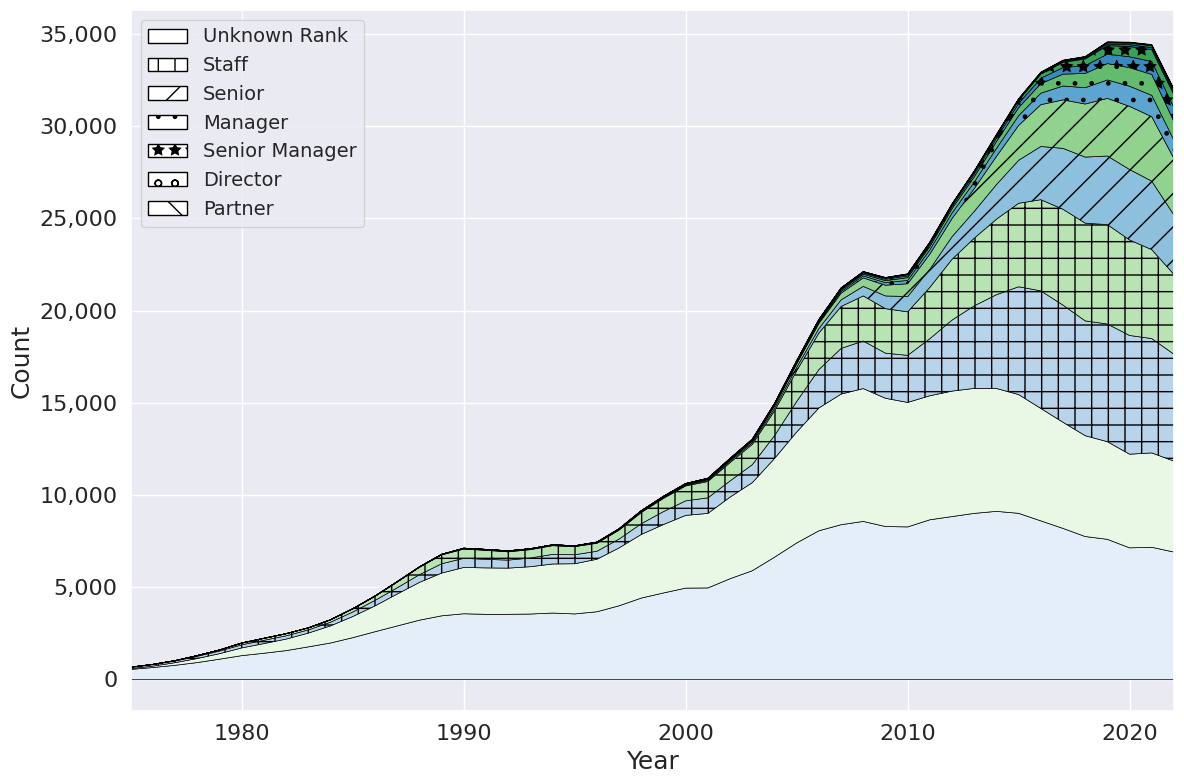

In [75]:
# Create a new dataset that can be used to create a stackplot
revB4AudExpSP = revB4AudExp.copy()
revB4AudExpSP.loc[revB4AudExpSP['badrankdummy'] == 1, 'positionrank'] = 0

# Group data by year, female, and positionrank, then count occurrences
revB4AudStata_grouped = (
    revB4AudExpSP.groupby(["year", "female", "positionrank"])
    .size()
    .reset_index(name="count")
)

# Create pivot table for the stackplot
revB4AudStata_pivot = revB4AudStata_grouped.pivot_table(
    index="year", columns=["female", "positionrank"], values="count", fill_value=0
)

# Define hard-coded fill patterns and progressive colors for ranks 0 to 6
male_cmap = plt.cm.Blues
female_cmap = plt.cm.Greens
male_colors = {rank: male_cmap(0.3 + 0.6 * (rank - 1) / 5) if rank > 0 else male_cmap(0.1) for rank in range(0, 7)}
female_colors = {rank: female_cmap(0.3 + 0.6 * (rank - 1) / 5) if rank > 0 else female_cmap(0.1) for rank in range(0, 7)}
patterns = {0: "", 1: "+", 2: "/", 3: ".", 4: "*", 5: "o", 6: "\\"}

# Prepare cumulative values for proper stacking
years = revB4AudStata_pivot.index
cumulative_data = np.zeros(len(years))

# Sort columns to ensure the desired order: male/rank1, female/rank1, male/rank2, female/rank2, ...
sorted_columns = sorted(
    revB4AudStata_pivot.columns,
    key=lambda col: (col[1], col[0])  # Sort by rank first, then by gender (male -> female)
)

# Update the legend to include only the descriptions for rank numbers
rank_descriptions = {
    0: "Unknown Rank",
    1: "Staff",
    2: "Senior",
    3: "Manager",
    4: "Senior Manager",
    5: "Director",
    6: "Partner"
}

fig, ax = plt.subplots(figsize=(12, 8))

# Reset cumulative data for stacking
cumulative_data = np.zeros(len(years))

# Plot stacked data in the specified order
for female, rank in sorted_columns:
    if (female, rank) not in revB4AudStata_pivot:
        continue  # Skip if the column is missing
    data = revB4AudStata_pivot[(female, rank)]
    color = female_colors[rank] if female else male_colors[rank]
    pattern = patterns[rank]
    ax.fill_between(
        years,
        cumulative_data,
        cumulative_data + data,
        color=color,
        hatch=pattern,
        edgecolor="black",
        linewidth=0.5
    )
    cumulative_data += data

# Create legend with only rank descriptions
handles = []
for rank, description in rank_descriptions.items():
    handles.append(
        mpatches.Patch(
            facecolor="white",  # Neutral background for legend
            edgecolor="black",
            hatch=patterns[rank],
            label=description  # Only the description, no "Rank X: "
        )
    )

# Define a function to format y-axis numbers with commas
def format_with_commas(x, pos):
    return f"{int(x):,}"

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_with_commas))

# Add title, labels, and legend
plt.xlabel("Year", fontsize=18)
plt.xlim([1975, 2022])
plt.ylabel("Count", fontsize=18)
plt.legend(handles=handles, loc="upper left", fontsize=14)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.tight_layout()

# Save the figure
plt.savefig(f"{directory_stub}/Gender-public/LaTeX/Figures/stackPlot.png", transparent=False, dpi=500, bbox_inches='tight')
plt.show()


In [76]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 33.34 minutes



#### .... Coefficients over time

In [77]:
print("Creating a plot of the coefficients over time")

Creating a plot of the coefficients over time


In [78]:
# Create dummy variables for each two-year period from 1990 to 2023
years = list(range(1990, 2024, 2))  # two-year periods starting in 1990

for start_year in years:
    end_year = start_year + 1
    # Create dummy: 1 if the year equals start_year or end_year, 0 otherwise
    revB4AudStata[f'year_{start_year}_{end_year}'] = (
        (revB4AudStata['year'] == start_year) | (revB4AudStata['year'] == end_year)
    ).astype(int)

# Create a dummy variable for all years prior to 1990
revB4AudStata['year_pre_1990'] = (revB4AudStata['year'] < 1990).astype(int)

# Create interaction terms between female and each two-year period dummy
for start_year in years:
    end_year = start_year + 1
    revB4AudStata[f'female_{start_year}_{end_year}'] = (
        revB4AudStata['female'] * revB4AudStata[f'year_{start_year}_{end_year}']
    )

# Create the interaction term between female and the pre-1990 dummy
revB4AudStata['female_pre_1990'] = revB4AudStata['female'] * revB4AudStata['year_pre_1990']

In [79]:
# Create dummy variables for each two-year period from 1990 to 2023
years = list(range(1990, 2024, 2))  # two-year periods starting in 1990

for start_year in years:
    end_year = start_year + 1
    # Create dummy: 1 if the year equals start_year or end_year, 0 otherwise
    revOtherFsStata[f'year_{start_year}_{end_year}'] = (
        (revOtherFsStata['year'] == start_year) | (revOtherFsStata['year'] == end_year)
    ).astype(int)

# Create a dummy variable for all years prior to 1990
revOtherFsStata['year_pre_1990'] = (revOtherFsStata['year'] < 1990).astype(int)

# Create interaction terms between female and each two-year period dummy
for start_year in years:
    end_year = start_year + 1
    revOtherFsStata[f'female_{start_year}_{end_year}'] = (
        revOtherFsStata['female'] * revOtherFsStata[f'year_{start_year}_{end_year}']
    )

# Create the interaction term between female and the pre-1990 dummy
revOtherFsStata['female_pre_1990'] = revOtherFsStata['female'] * revOtherFsStata['year_pre_1990']

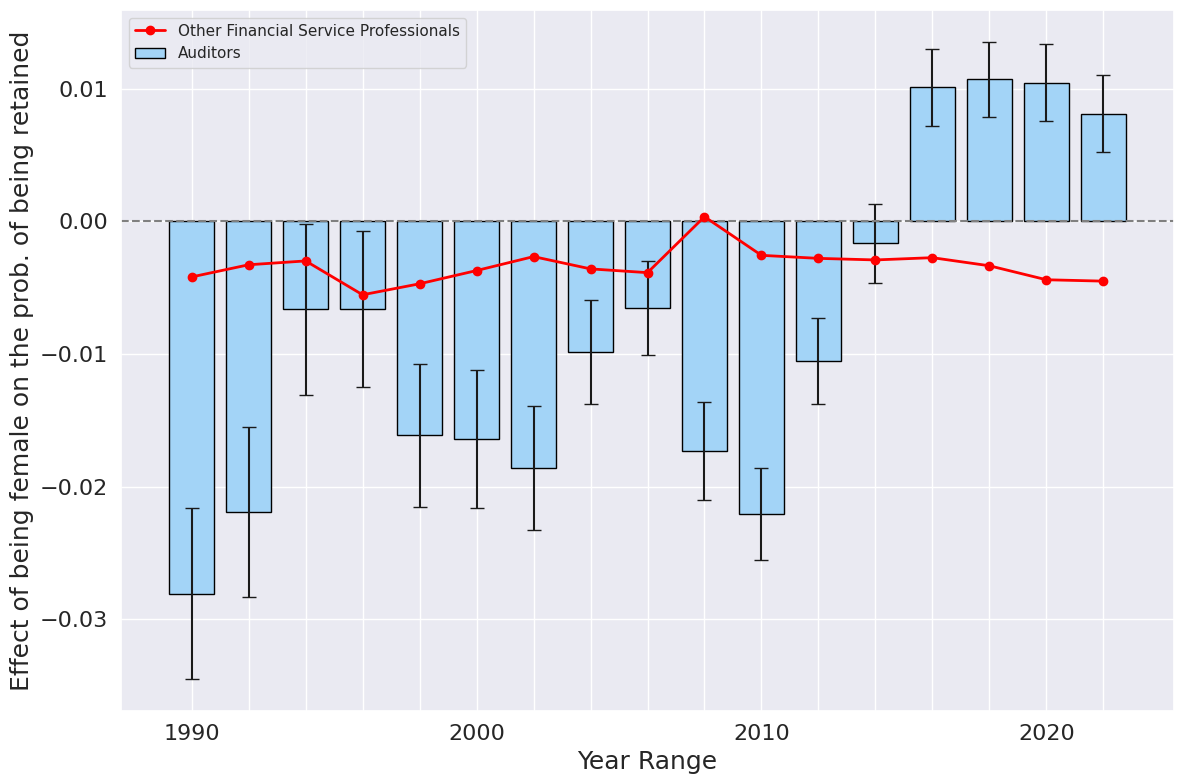

In [80]:
# ========================================================
# Part 1: Run regression on revB4AudStata dataset
# ========================================================
stata.pdataframe_to_data(revB4AudStata, force=True)
stata.run(
    'reghdfe retained female_1990_1991 female_1992_1993 female_1994_1995 '
    'female_1996_1997 female_1998_1999 female_2000_2001 female_2002_2003 '
    'female_2004_2005 female_2006_2007 female_2008_2009 female_2010_2011 '
    'female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 '
    'female_2020_2021 female_2022_2023 female_pre_1990 masterorhigher top_university api black other, '
    'absorb(auditorkey ib2000.year yearfirst) vce(cluster userid)', quietly=True
)
reg_results_b4aud = stata.get_ereturn()  # Extract the regression results

# Extract coefficients, standard errors, and variable names for revB4AudStata
coefficients_b4aud = reg_results_b4aud['e(b)'].flatten()  # Flatten the coefficient array
std_errors_b4aud = reg_results_b4aud['e(V)'].diagonal()**0.5  # Standard errors
variable_names_b4aud = reg_results_b4aud['e(indepvars)'].split()  # List of independent variable names

# Variables of interest (only the 'female_' dummies)
variables_of_interest = [
    'female_1990_1991', 'female_1992_1993', 'female_1994_1995', 'female_1996_1997', 'female_1998_1999', 
    'female_2000_2001', 'female_2002_2003', 'female_2004_2005', 'female_2006_2007', 'female_2008_2009',
    'female_2010_2011', 'female_2012_2013', 'female_2014_2015', 'female_2016_2017', 'female_2018_2019', 
    'female_2020_2021', 'female_2022_2023'
]

# Filter coefficients and standard errors for the variables of interest for revB4AudStata
filtered_coefficients_b4aud = [
    coefficients_b4aud[variable_names_b4aud.index(var)] for var in variables_of_interest
]
filtered_std_errors_b4aud = [
    std_errors_b4aud[variable_names_b4aud.index(var)] for var in variables_of_interest
]


# ========================================================
# Part 2: Run regression on revOtherFsStata dataset
# ========================================================
stata.pdataframe_to_data(revOtherFsStata, force=True)
stata.run(
    'reghdfe retained female_1990_1991 female_1992_1993 female_1994_1995 '
    'female_1996_1997 female_1998_1999 female_2000_2001 female_2002_2003 '
    'female_2004_2005 female_2006_2007 female_2008_2009 female_2010_2011 '
    'female_2012_2013 female_2014_2015 female_2016_2017 female_2018_2019 '
    'female_2020_2021 female_2022_2023 female_pre_1990 masterorhigher top_university api black other, '
    'absorb(ultimate_parent_rcid ib2000.year yearfirst) vce(cluster userid)', quietly=True
)
reg_results_other = stata.get_ereturn()  # Extract regression results for the second dataset

# Extract coefficients, standard errors, and variable names for revOtherFsStata
coefficients_other = reg_results_other['e(b)'].flatten()
std_errors_other = reg_results_other['e(V)'].diagonal()**0.5
variable_names_other = reg_results_other['e(indepvars)'].split()

# Filter coefficients (and optionally std errors) for the variables of interest for revOtherFsStata
filtered_coefficients_other = [
    coefficients_other[variable_names_other.index(var)] for var in variables_of_interest
]
filtered_std_errors_other = [
    std_errors_other[variable_names_other.index(var)] for var in variables_of_interest
]


# ========================================================
# Part 3: Plotting
# ========================================================
# Define the positions and x-axis labels for the periods
x_positions = range(len(variables_of_interest))
year_labels = ['1990', '', '', '', '', '2000', '', '', '', '', '2010', '', '', '', '', '2020', '']  # Only label decades

plt.figure(figsize=(12, 8))

# Plot the bar chart from the first regression (revB4AudStata)
plt.bar(
    x_positions, filtered_coefficients_b4aud, yerr=filtered_std_errors_b4aud, 
    color='#A3D4F7', edgecolor='black', capsize=5, label='Auditors'
)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='--')

# Overlay the coefficients from the second regression (revOtherFsStata) as a line plot with markers
plt.plot(
    x_positions, filtered_coefficients_other, color='red', marker='o', linestyle='-', 
    linewidth=2, label='Other Financial Service Professionals'
)

plt.xlabel('Year Range', fontsize=18)
plt.ylabel('Effect of being female on the prob. of being retained', fontsize=18)
plt.xticks(ticks=x_positions, labels=year_labels, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig(f"{directory_stub}/Gender-public/LaTeX/Figures/femaleCoeffPlot.png", transparent=False, dpi=500, bbox_inches='tight')
plt.show()

In [81]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 62.36 minutes



#### .... Survival curves

In [82]:
print("Creating survival curves")

Creating survival curves


In [83]:
# Collapse the data down to a single observation per auditor for survival analysis
revB4AudSurv = revB4AudStata.copy()

# Create a year_last variable based on the year of user_firm_enddate
revB4AudSurv['yearlast'] = revB4AudSurv['user_firm_enddate'].dt.year

revB4AudSurv = revB4AudSurv[['userid','yearfirst','yearlast','female','masterorhigher', 'top_university', 'year']]
revB4AudSurv.drop_duplicates(subset = 'userid', inplace = True)

revB4AudSurv['LOS'] = revB4AudSurv['yearlast'] - revB4AudSurv['yearfirst']
revB4AudSurv['CENSOR'] = 1; revB4AudSurv.loc[revB4AudSurv['yearlast'] >= 2023, 'CENSOR'] = 0

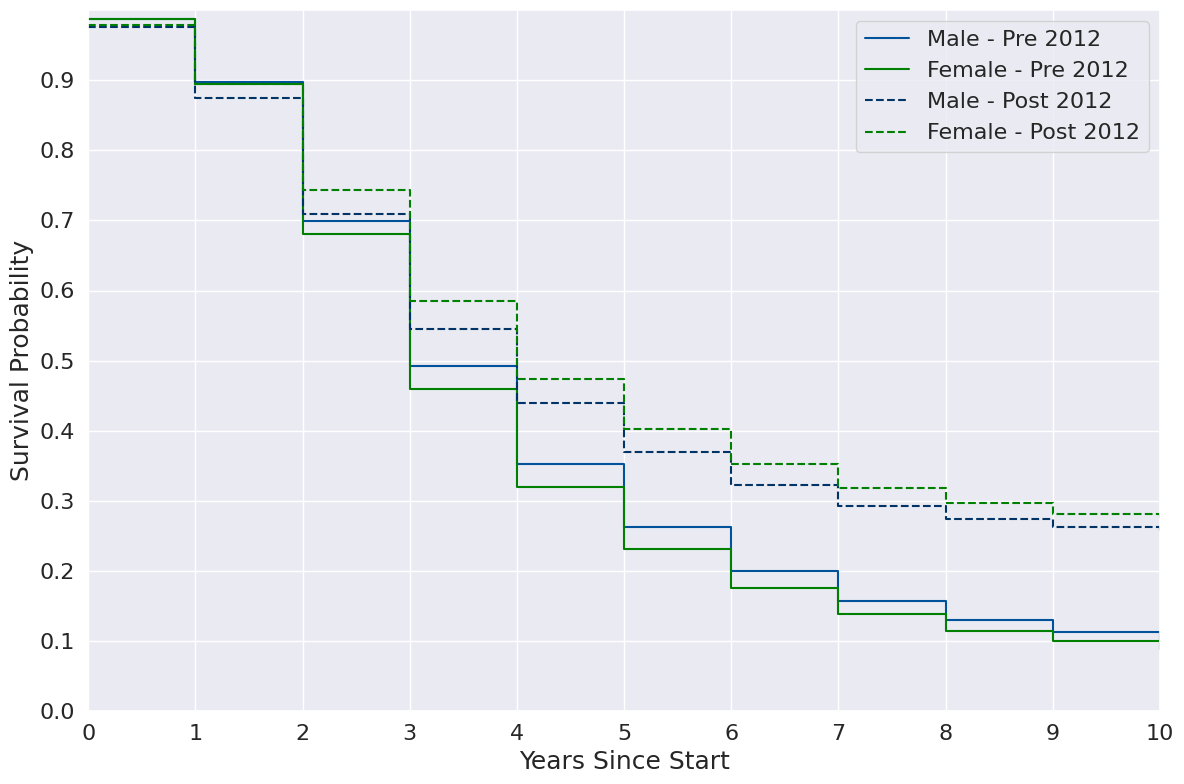

In [84]:
# Set figure size
plt.figure(figsize=(12, 8))

# Plot pre-2012 curves
dfuse_pre = revB4AudSurv[(revB4AudSurv['year'] < 2012)]
kmf1 = KaplanMeierFitter()

T_pre = dfuse_pre['LOS']
E_pre = dfuse_pre['CENSOR']

groups_pre = revB4AudStata['female']
i1_pre = (groups_pre == 0)
i2_pre = (groups_pre == 1)

# Plot Male - Pre 2012
kmf1.fit(T_pre[i1_pre], E_pre[i1_pre], label='Male - Pre 2012')
ax = kmf1.plot(color="#00529B", ci_show=True, ci_alpha=0.0)  

# Plot Female - Pre 2012
kmf1.fit(T_pre[i2_pre], E_pre[i2_pre], label='Female - Pre 2012')
kmf1.plot(ax=ax, color='green', ci_show=True, ci_alpha=0.0)  

# Plot post-2012 curves
dfuse_post = revB4AudSurv[(revB4AudSurv['year'] >= 2012)]

T_post = dfuse_post['LOS']
E_post = dfuse_post['CENSOR']

groups_post = revB4AudStata['female']
i1_post = (groups_post == 0)
i2_post = (groups_post == 1)

# Plot Male - Post 2012
kmf1.fit(T_post[i1_post], E_post[i1_post], label='Male - Post 2012')
kmf1.plot(ax=ax, color="#003366", linestyle='--', ci_show=True, ci_alpha=0.0)  

# Plot Female - Post 2012
kmf1.fit(T_post[i2_post], E_post[i2_post], label='Female - Post 2012')
kmf1.plot(ax=ax, color="green", linestyle='--', ci_show=True, ci_alpha=0.0)  

# Settings for figure appearance
plt.xlim([1, 10])
plt.xticks(range(0, 11), fontsize=16)
plt.ylim([0, 1])
plt.yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9], fontsize=16)
plt.xlabel('Years Since Start', fontsize=18)
plt.ylabel('Survival Probability', fontsize=18)

# Adjust the layout and add legend
plt.tight_layout()
plt.legend(fontsize=16, frameon=1)

# Save the figure
plt.savefig(f"{directory_stub}/Gender-public/LaTeX/Figures/survivalCurves.png", transparent=False, dpi=500, bbox_inches='tight')

# Display the plot
plt.show()

In [85]:
'''
Print the time that has passed since the start of the analysis
'''

print("Status Check")
print(f'Time elapsed: {(time.time() - start_time)/60:.2f} minutes')
print()


Status Check
Time elapsed: 62.38 minutes



# Complete

In [86]:
print('The analysis code is finished running. Check the LaTeX directories for tables and figures.')

The analysis code is finished running. Check the LaTeX directories for tables and figures.
